# import dependency

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import modlamp.descriptors
import modlamp.analysis
import modlamp.sequences
import numpy as np
import numpy.ma as ma  
import pandas as pd
import csv
import random
import seaborn as sns
from joblib import load, dump
from sklearn.model_selection import train_test_split
import amp.data_utils.data_loader as data_loader
from amp.config import MIN_LENGTH, MAX_LENGTH
from amp.data_utils.sequence import pad, to_one_hot
from amp.utils.generate_peptides import translate_peptide
from amp.utils import phys_chem_propterties as phys
from amp.inference import HydrAMPGenerator
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
from scipy.stats import mannwhitneyu

import modlamp.descriptors
import modlamp.analysis
import modlamp.sequences


Using TensorFlow backend.


# Amino acid composition

In [13]:
seed = 7
sns.set_style('whitegrid', {'grid.color': '.95', 'axes.spines.right': False, 'axes.spines.top': False})
params = {'axes.labelsize': 14,'axes.titlesize':14, 'font.size': 14, 'legend.fontsize': 14, 'xtick.labelsize': 14, 'ytick.labelsize': 14}
plt.rcParams.update(params)

In [14]:
models = ['HydrAMP']
model_labels = ['hydramp']
hydra_color = '#B80018'

In [15]:
def get_aa_composition(data):
    STD_AA = list('ACDEFGHIKLMNPQRSTVWY')
    seq = ''.join(data)
    count = len(seq)

    aa_comp = {}
    for aa in STD_AA:
        aa_comp[aa] = seq.count(aa) / count
    return aa_comp

## optimize amp only

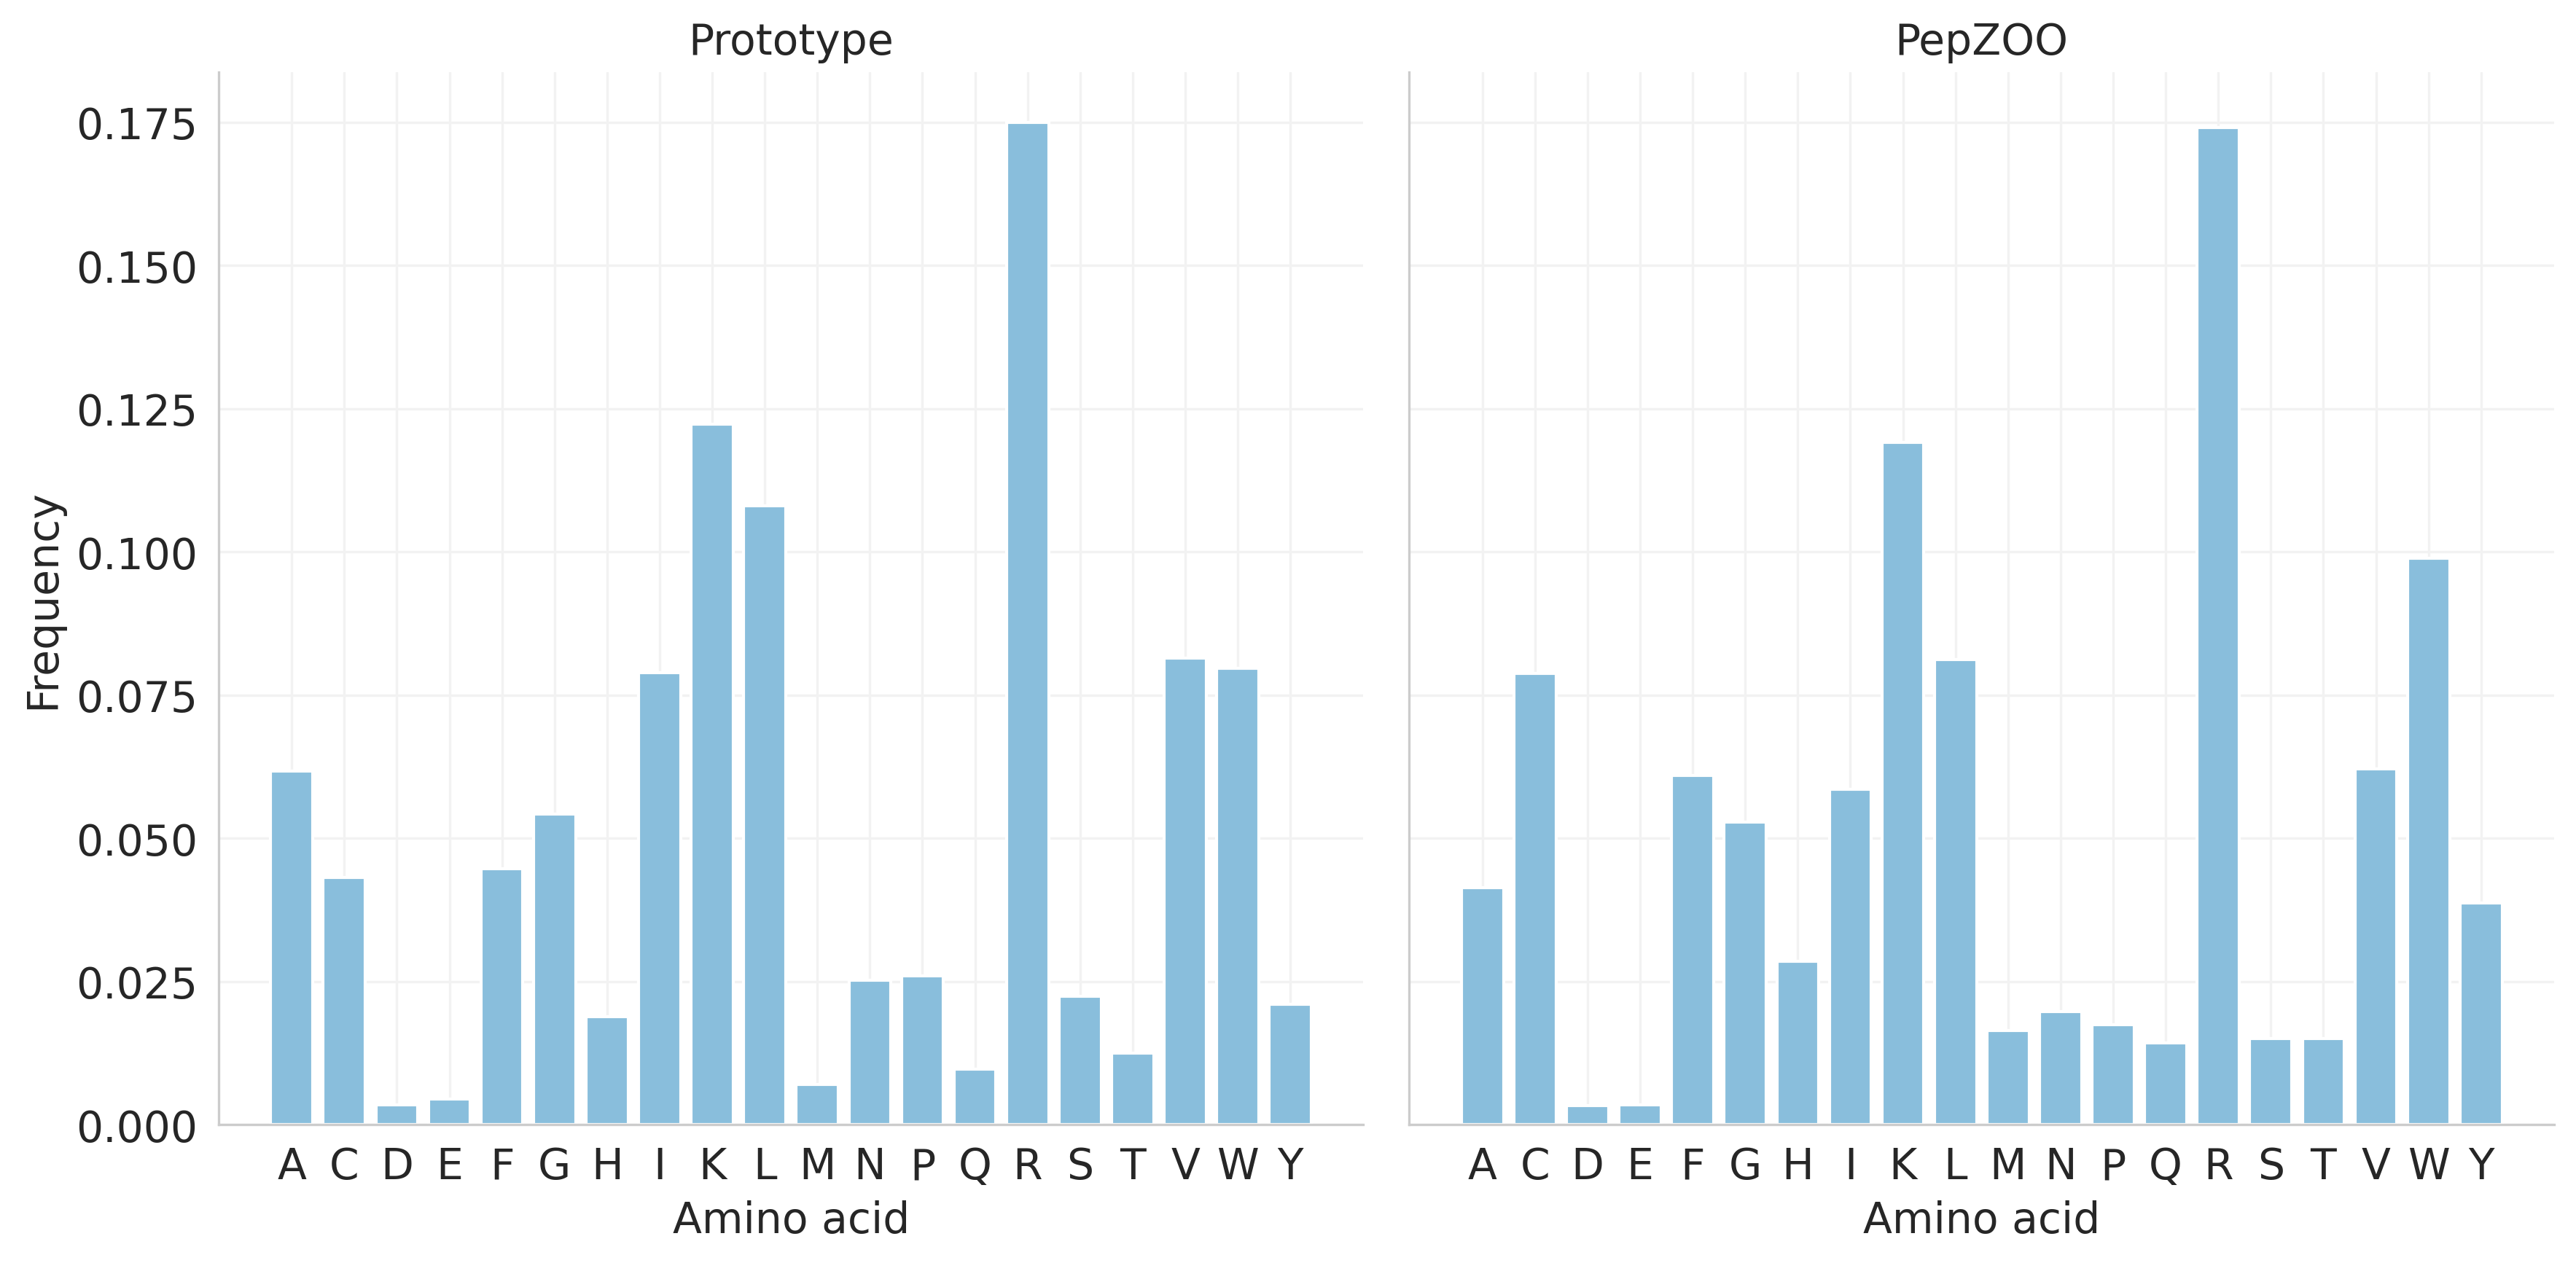

In [15]:
amp_result_f = open('../../result/hydramp/amp_case1.csv','r')
amp_result_reader = csv.reader(amp_result_f)
next(amp_result_reader)
amp_prototype_list = []
amp_PepZOO_list = []

for row in amp_result_reader:
    _, t = row[0].split('_')
    if t == 'original':
        amp_prototype_list.append(row[1])
    if t == 'HydrampZeroOpt':
        amp_PepZOO_list.append(row[1])

amp_result_f.close()

fig, ((ax1,ax2)) = plt.subplots(
    nrows=1,
    ncols=2, 
    figsize=(12, 6), 
    dpi=300, 
    sharey=True,
    # gridspec_kw={'width_ratios': [1, 2, 2, 2]}
)
aa_dict = {}
for i, (ax, data, title) in enumerate(zip(
    [ax1, ax2],
    [prototype_list, amp_PepZOO_list],
    [
        'Prototype', 
        'PepZOO'
    ]
    )):
    aa_composition = get_aa_composition(data)
    aa_dict[f'{title}'] = aa_composition
    # clrs = ['firebrick' if (x in ['K', 'E', 'C', 'R', 'D']) else '#89bedc' for x in list(aa_composition.keys())]
    clrs = ['#89bedc' for x in list(aa_composition.keys())]
    ax.bar(x=list(aa_composition.keys()), height=list(aa_composition.values()), color=clrs)
    ax.set_title(title)

ax1.set_ylabel('Frequency')
ax1.set_xlabel('Amino acid', x=0.5)
# ax2.set_ylabel('Frequency')
ax2.set_xlabel('Amino acid', x=0.5)
fig.tight_layout()
plt.savefig('../figures/figure/amp_case1_all_aacomposition.svg')

## optimize mic only

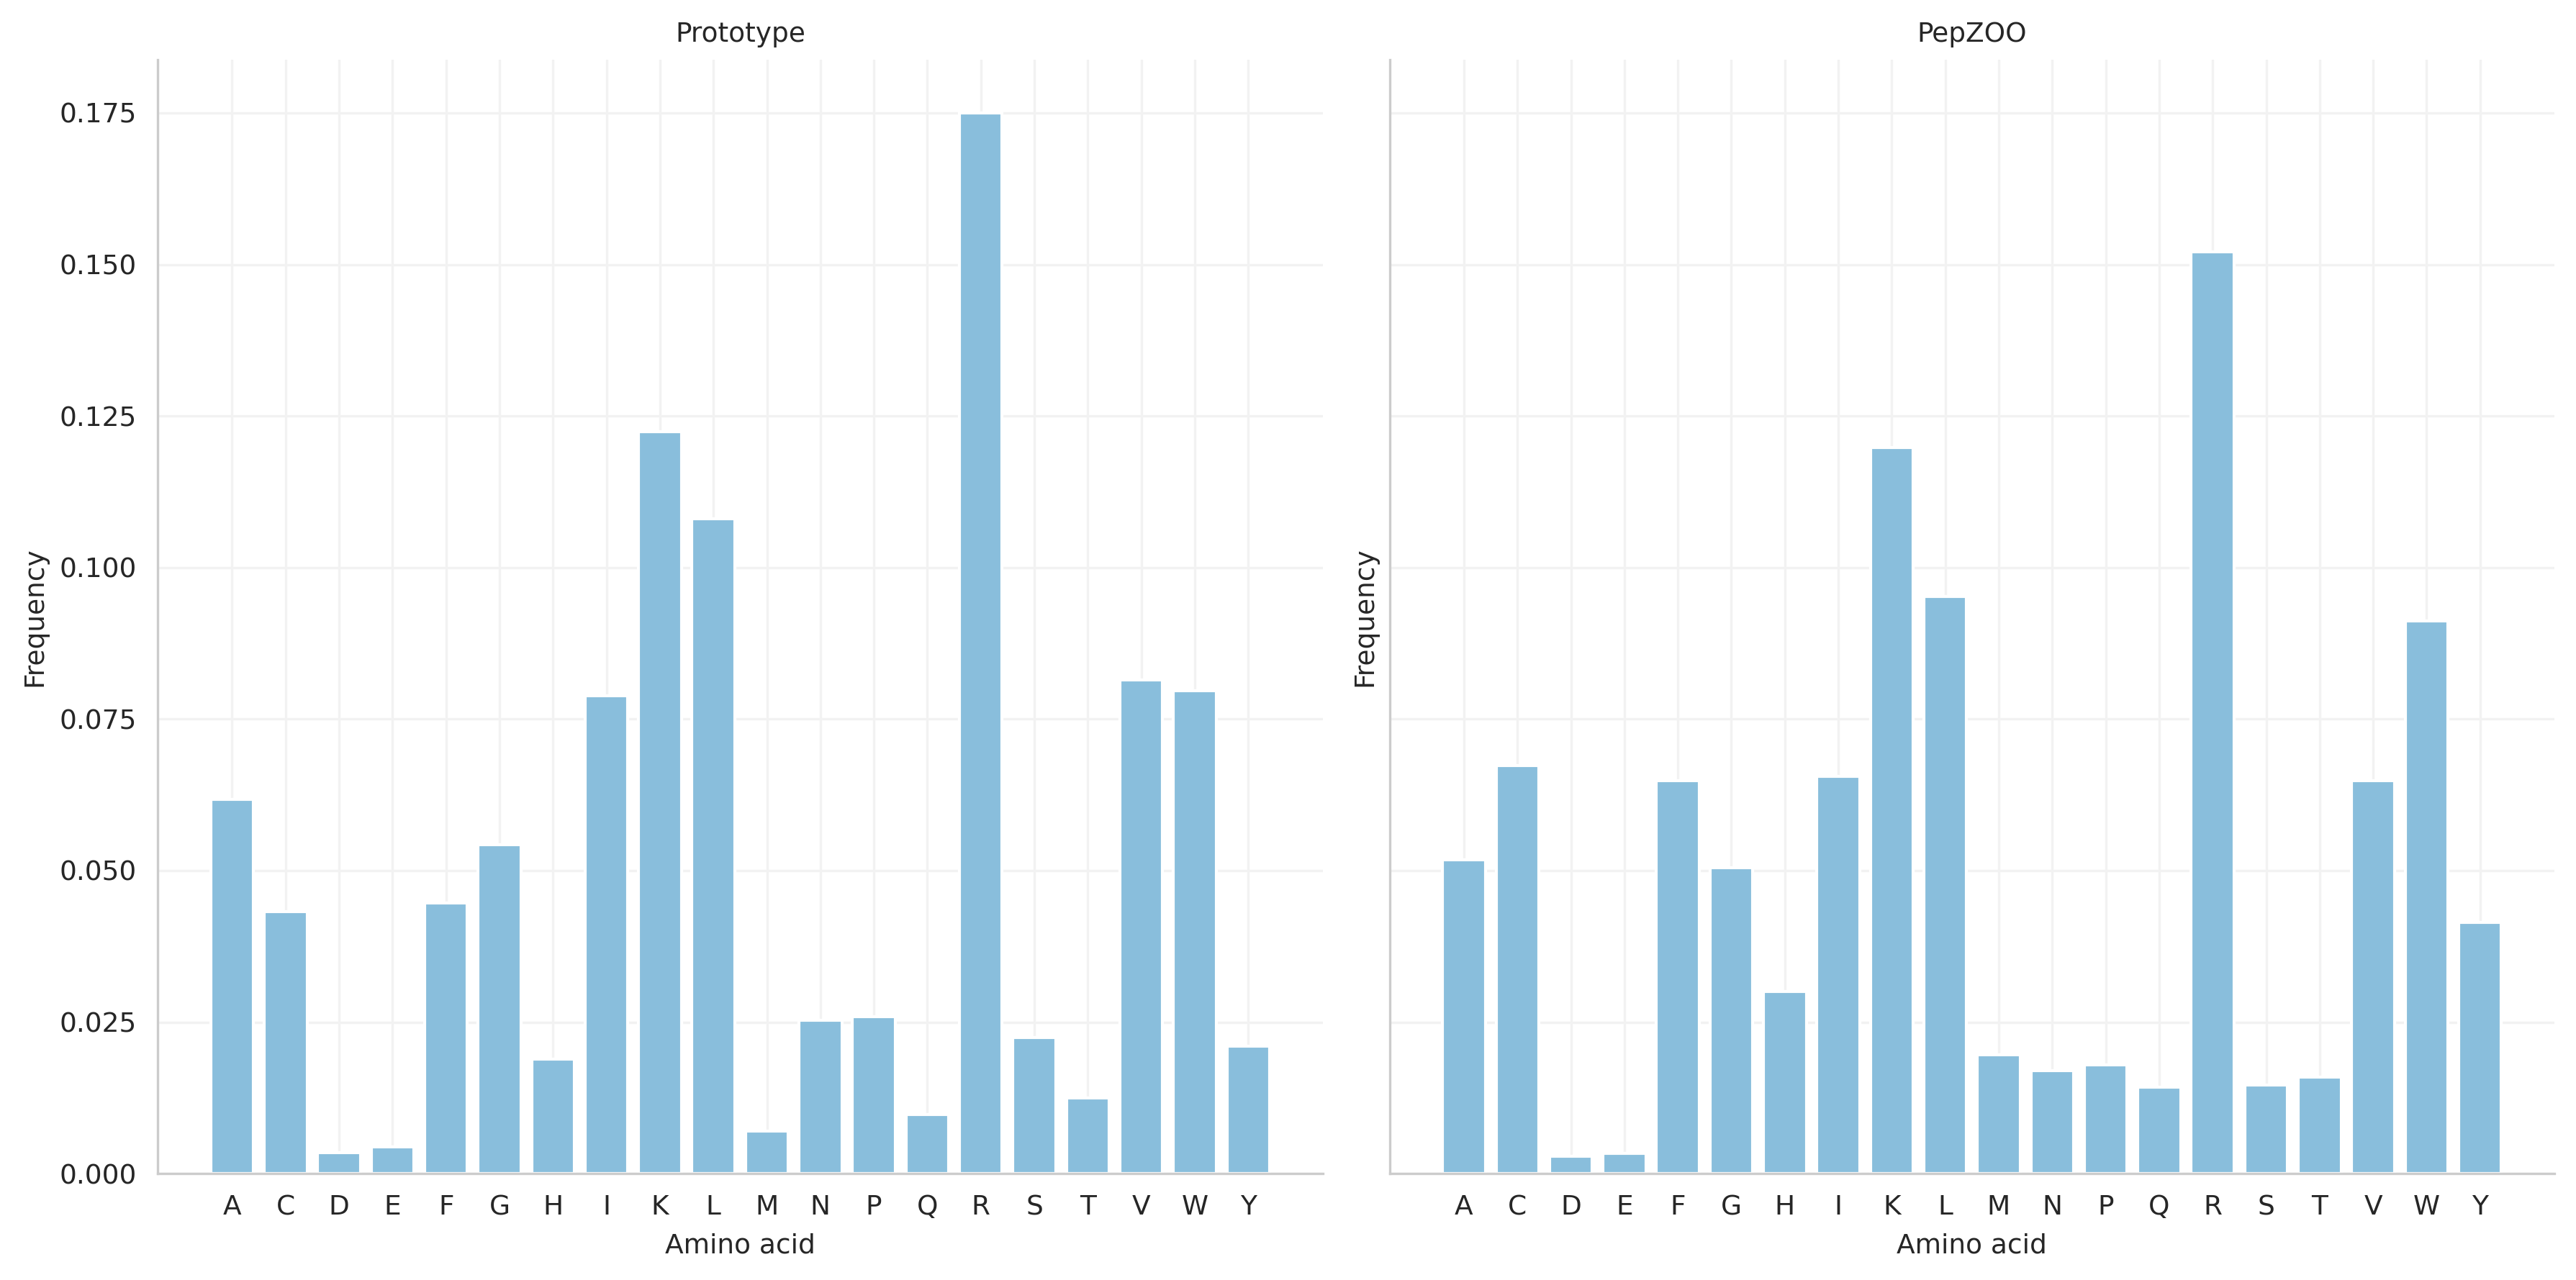

In [18]:
hydra_f = open('../../result/hydramp/mic_case1.csv','r')
hydra_reader = csv.reader(hydra_f)
next(hydra_reader)
prototype_list = []
hydra_zero_list = []

for row in hydra_reader:
    _, t = row[0].split('_')
    if t == 'original':
        prototype_list.append(row[1])
    if t == 'HydrampZeroOpt':
        hydra_zero_list.append(row[1])

hydra_f.close()

fig, ((ax1,ax2)) = plt.subplots(
    nrows=1,
    ncols=2, 
    figsize=(12, 6), 
    dpi=300, 
    sharey=True,
    # gridspec_kw={'width_ratios': [1, 2, 2, 2]}
)
aa_dict = {}
for i, (ax, data, title) in enumerate(zip(
    [ax1, ax2],
    [prototype_list, hydra_zero_list],
    [
        'Prototype', 
        'PepZOO'
    ]
    )):
    aa_composition = get_aa_composition(data)
    aa_dict[f'{title}'] = aa_composition
    # clrs = ['firebrick' if (x in ['K', 'E', 'C', 'R', 'D']) else '#89bedc' for x in list(aa_composition.keys())]
    clrs = ['#89bedc' for x in list(aa_composition.keys())]
    ax.bar(x=list(aa_composition.keys()), height=list(aa_composition.values()), color=clrs)
    ax.set_title(title)

ax1.set_ylabel('Frequency')
ax1.set_xlabel('Amino acid', x=0.5)
ax2.set_ylabel('Frequency')
ax2.set_xlabel('Amino acid', x=0.5)
fig.tight_layout()
plt.savefig('../figures/figure/mic_case1_all_aacomposition.svg')

## optimize amp and mic

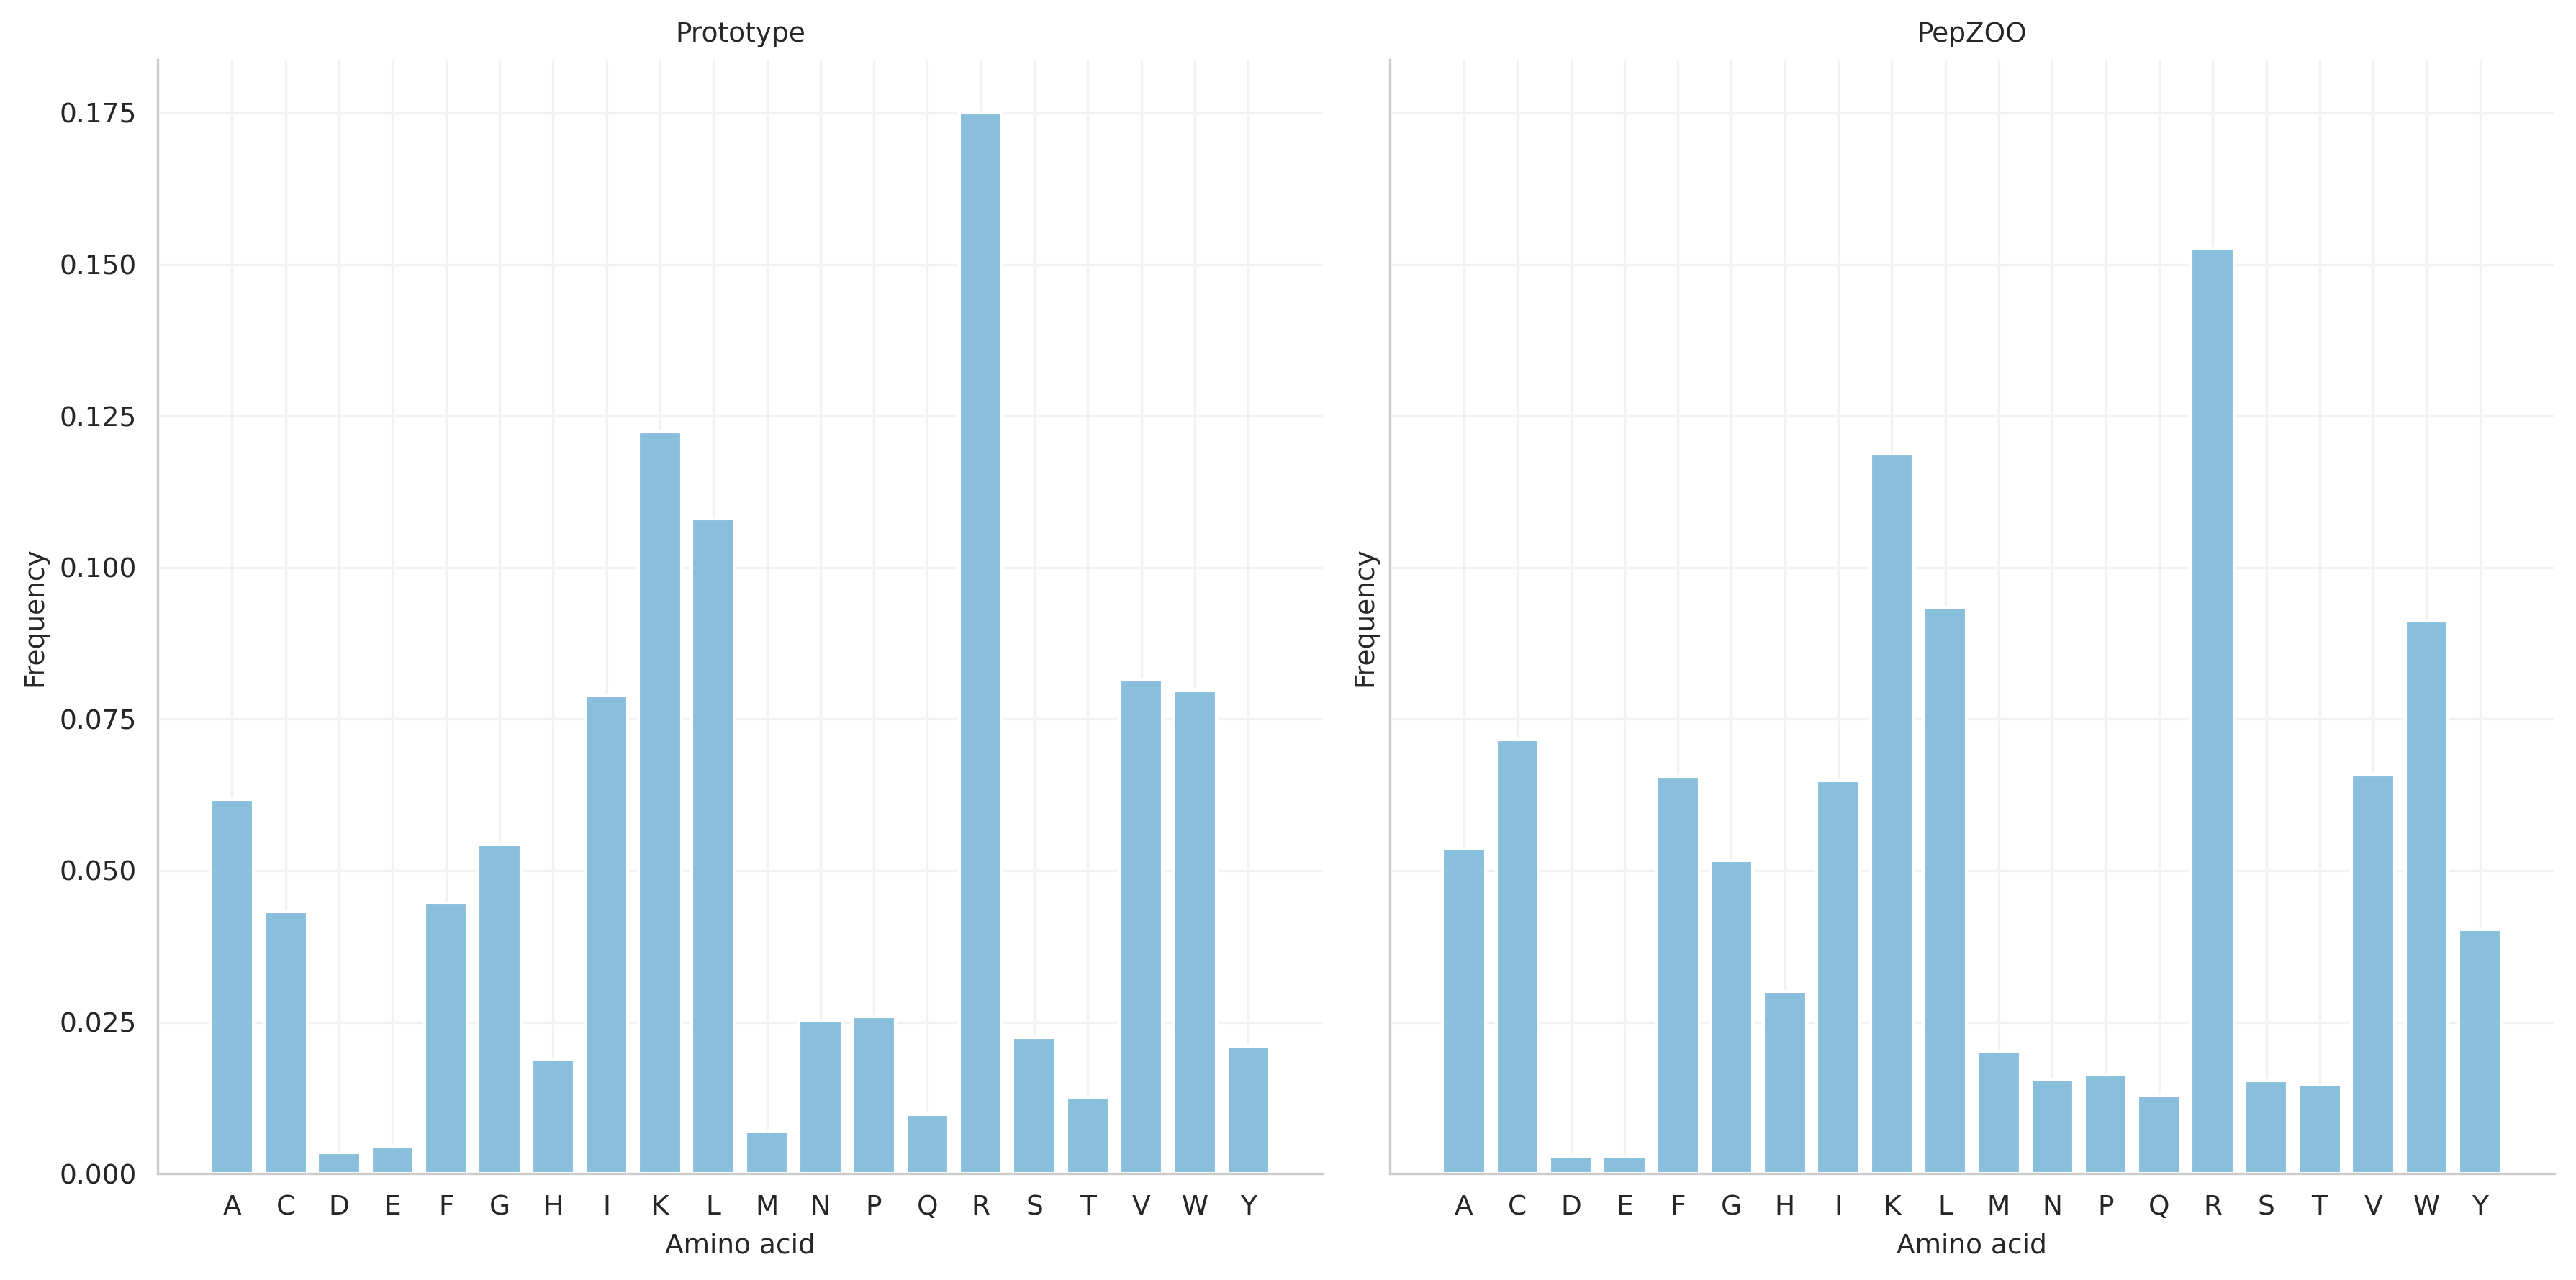

In [19]:
hydra_f = open('../../result/hydramp/amp_mic_case1.csv','r')
hydra_reader = csv.reader(hydra_f)
next(hydra_reader)
prototype_list = []
hydra_zero_list = []

for row in hydra_reader:
    _, t = row[0].split('_')
    if t == 'original':
        prototype_list.append(row[1])
    if t == 'HydrampZeroOpt':
        hydra_zero_list.append(row[1])

hydra_f.close()

fig, ((ax1,ax2)) = plt.subplots(
    nrows=1,
    ncols=2, 
    figsize=(12, 6), 
    dpi=300, 
    sharey=True,
    # gridspec_kw={'width_ratios': [1, 2, 2, 2]}
)
aa_dict = {}
for i, (ax, data, title) in enumerate(zip(
    [ax1, ax2],
    [prototype_list, hydra_zero_list],
    [
        'Prototype', 
        'PepZOO'
    ]
    )):
    aa_composition = get_aa_composition(data)
    aa_dict[f'{title}'] = aa_composition
    # clrs = ['firebrick' if (x in ['K', 'E', 'C', 'R', 'D']) else '#89bedc' for x in list(aa_composition.keys())]
    clrs = ['#89bedc' for x in list(aa_composition.keys())]
    ax.bar(x=list(aa_composition.keys()), height=list(aa_composition.values()), color=clrs)
    ax.set_title(title)

ax1.set_ylabel('Frequency')
ax1.set_xlabel('Amino acid', x=0.5)
ax2.set_ylabel('Frequency')
ax2.set_xlabel('Amino acid', x=0.5)
fig.tight_layout()
plt.savefig('../figures/figure/amp_mic_case1_all_aacomposition.svg')

# P_AMP and P_MIC

In [2]:
sns.set_style(
    'whitegrid', 
    {
        'grid.color': '.95',
        'axes.spines.right': False,
        'axes.spines.top': False,
    }
)

params = {
    'axes.labelsize': 10,
    'axes.titlesize':10,
    'font.size': 10, 
    'legend.fontsize': 10,
    'xtick.labelsize': 10, 
    'ytick.labelsize': 10,
}

plt.rcParams.update(params)

palette_models = {  
    'Prototype': '#ffd23f',
    'PepZOO_amp': '#AF55FF',
    'PepZOO_mic': '#A69FFF',
    'PepZOO_amp_mic': '#1d3557',
    'HydrAMP': '#B80018',
    'PepCVAE': '#0F5257',     
    'Basic': '#660708',         
}

In [ ]:
def get_amp_mic_data(hydr_file_path, pepcvae_file_path, basic_file_path):
    models = ['basic', 'pepcvae', 'hydramp']
    data = []
    hydr_file = open(hydr_file_path,'r')
    pepcvae_file = open(pepcvae_file_path,'r')
    basic_file = open(basic_file_path,'r')
    hydr_reader = csv.reader(hydr_file)
    pepcvae_reader = csv.reader(pepcvae_file)
    basic_reader = csv.reader(basic_file)
    next(hydr_reader)
    next(basic_reader)
    next(pepcvae_reader)
    prototype_amp_list = []
    prototype_mic_list = []
    hydramp_amp_list = []
    hydramp_mic_list = []
    hydramp_zero_amp_list = []
    hydramp_zero_mic_list = []
    basic_amp_list = []
    basic_mic_list = []
    basic_zero_amp_list = []
    basic_zero_mic_list = []

    pepcvae_amp_list = []
    pepcvae_mic_list = []
    pepcvae_zero_amp_list = []
    pepcvae_zero_mic_list = []

    for row in hydr_reader:
        _, t = row[0].split('_')
        if t == 'original':
            prototype_amp_list.append(float(row[2]))
            prototype_mic_list.append(float(row[3]))
        if t == 'HydrampOpt':
            hydramp_amp_list.append(float(row[2]))
            hydramp_mic_list.append(float(row[3]))
        if t == 'HydrampZeroOpt':
            hydramp_zero_amp_list.append(float(row[2]))
            hydramp_zero_mic_list.append(float(row[3]))
    for row in basic_reader:
        _, t = row[0].split('_')
        if t == 'BasicOpt':
            basic_amp_list.append(float(row[2]))
            basic_mic_list.append(float(row[3]))
        if t == 'BasicZeroOpt':
            basic_zero_amp_list.append(float(row[2]))
            basic_zero_mic_list.append(float(row[3]))

    for row in pepcvae_reader:
        _, t = row[0].split('_')
        if t == 'PepCVAEOpt':
            pepcvae_amp_list.append(float(row[2]))
            pepcvae_mic_list.append(float(row[3]))
        if t == 'PepCVAEZeroOpt':
            pepcvae_zero_amp_list.append(float(row[2]))
            pepcvae_zero_mic_list.append(float(row[3]))

    data.append([hydramp_zero_amp_list, hydramp_zero_mic_list])
    data.append([hydramp_amp_list, hydramp_mic_list])
    # data.append([pepcvae_zero_amp_list, pepcvae_zero_mic_list])  
    data.append([pepcvae_amp_list, pepcvae_mic_list])  
    # data.append([basic_zero_amp_list, basic_zero_mic_list])
    data.append([basic_amp_list, basic_mic_list])
    hydr_file.close()
    basic_file.close()
    pepcvae_file.close()  
    return prototype_amp_list, prototype_mic_list, data


def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value


def set_axis_style(ax, data, k):
    quartile1, medians, quartile3 = np.array([np.percentile(data_, [25, 50, 75], axis=0) for data_ in data]).T
    whiskers = np.array([
        adjacent_values(sorted_array, q1, q3)
        for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
    inds = np.arange(1, len(medians) + 1)
    ax.scatter(inds, medians, marker='o', lw=0.5, edgecolors='k', color='white', s=15, zorder=3)
    ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=0.5)
    ax.xaxis.set_ticks_position('bottom')
    # ax.set_xticks([1,2,3,4])
    # ax.set_xticklabels([k,k,k,k])


def generate_classifier_distribution_plot(
    prototype_amp,
    prototype_mic,
    optimized_amp,
    optimized_mic,
):
    

    fig, (ax0a, ax1, ax0b, ax2) = plt.subplots(
        nrows=1, 
        ncols=4, 
        figsize=(6, 2.5),
        dpi=300,
        sharey=True,
        gridspec_kw={'width_ratios': [1, 4, 1, 4]}
    )

    ax0a_parts = ax0a.violinplot(
        dataset=prototype_amp,
        showmeans=False,
        showmedians=False,
        showextrema=False,
        widths=0.85, 

    )

    ax0b_parts = ax0b.violinplot(
        dataset=prototype_mic,
        showmeans=False,
        showmedians=False,
        showextrema=False,
        widths=0.85, 
    )
    
    set_axis_style(ax0a, [prototype_amp], 'AMP and MIC before')
    set_axis_style(ax0b, [prototype_mic], 'AMP and MIC before')

    for parts, color in zip([ax0a_parts, ax0b_parts], ['#ffd23f', '#540d6e']):
        for pc in parts['bodies']:
            pc.set_facecolor(color)
            pc.set_edgecolor('black')
            pc.set_linewidth(0.0)
            pc.set_alpha(1)   

    for ax in [ax0a, ax0b]:
        ax.set_xticks([1])
        ax.set_xticklabels(['Prototype'])
        # ax.set_xticklabels([])

    ax0a.set_ylabel('$P_{AMP}$')
    ax0b.set_ylabel('$P_{MIC}$')




    parts1 = ax1.violinplot(
        dataset=optimized_amp,
        showmeans=False,
        showmedians=False,
        showextrema=False,
        widths=0.85, 
    )

    set_axis_style(ax1, optimized_amp, 'Optimized')

    parts2 = ax2.violinplot(
        dataset=optimized_mic,
        showmeans=False,
        showmedians=False,
        showextrema=False,
        widths=0.85, 
    )
    set_axis_style(ax2, optimized_mic, 'Optimized')

    for ax in [ax1, ax2]:
        ax.spines['left'].set_visible(False)

    for parts in [parts1, parts2]:
        for pc, color in zip(parts['bodies'], palette_models.values()):
            pc.set_facecolor(color)
            pc.set_edgecolor('black')
            pc.set_linewidth(0.0)
            pc.set_alpha(1)
    
    for i, (label, ax) in enumerate(
    zip(['e', 'f'], [ax0a, ax0b])
    ):
        ax.annotate(label, xy=(0.1, 1.08), xycoords='axes fraction',
          fontweight='bold', va='top', ha='right')
    
    ax1.set_xticks([1,2,3,4])
    ax1.set_xticklabels(['PepZOO', 'HydrAMP', 'PepCVAE', 'Basic'])
    ax1.annotate('Case 1 generation from prototypes', xy=(1.5, 1.15), xycoords='axes fraction', fontweight='bold', va='top', ha='right') 
    # ax1.set_xticklabels([])
    # ax2.set_xticklabels([])
    ax2.set_xticks([1,2,3,4])
    ax2.set_xticklabels(['PepZOO', 'HydrAMP', 'PepCVAE', 'Basic'])
    # fig.autofmt_xdate(rotation=45)
    return fig


def plot_classifier_distribution(data, prototype_amp, prototype_mic):
    
    optimized_amp = [x[0] for x in data]
    optimized_mic = [x[1] for x in data]
    
    fig = generate_classifier_distribution_plot(
        prototype_amp,
        prototype_mic,
        optimized_amp,
        optimized_mic,
    )

    return fig    

## optimize amp only

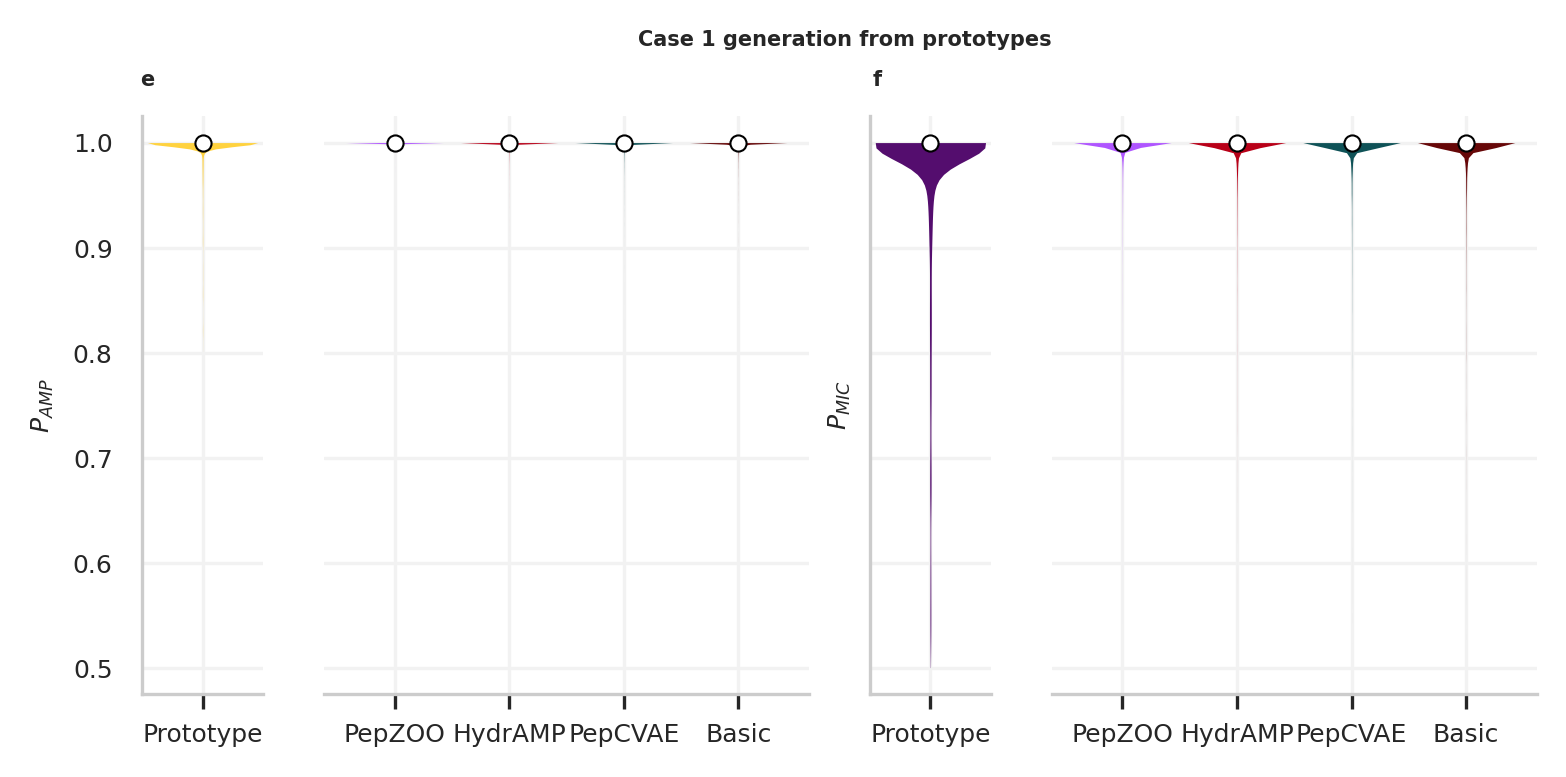

In [29]:
amp_file_path = '../../result/hydramp/amp_case1.csv'
mic_file_path = '../../result/hydramp/mic_case1.csv'
amp_mic_file_path = '../../result/hydramp/amp_mic_case1.csv'
pepcvae_file_path  = '../../result/pepcvae/case1_result.csv'
basic_file_path = '../../result/basic/case1_result.csv'
prototype_amp_list, prototype_mic_list, data = get_amp_mic_data(amp_file_path, pepcvae_file_path, basic_file_path)
fig = plot_classifier_distribution(data, prototype_amp_list, prototype_mic_list)
fig.savefig("../figures/figure/amp_case1_amp_mic.svg")
plt.show()

## optimize mic only

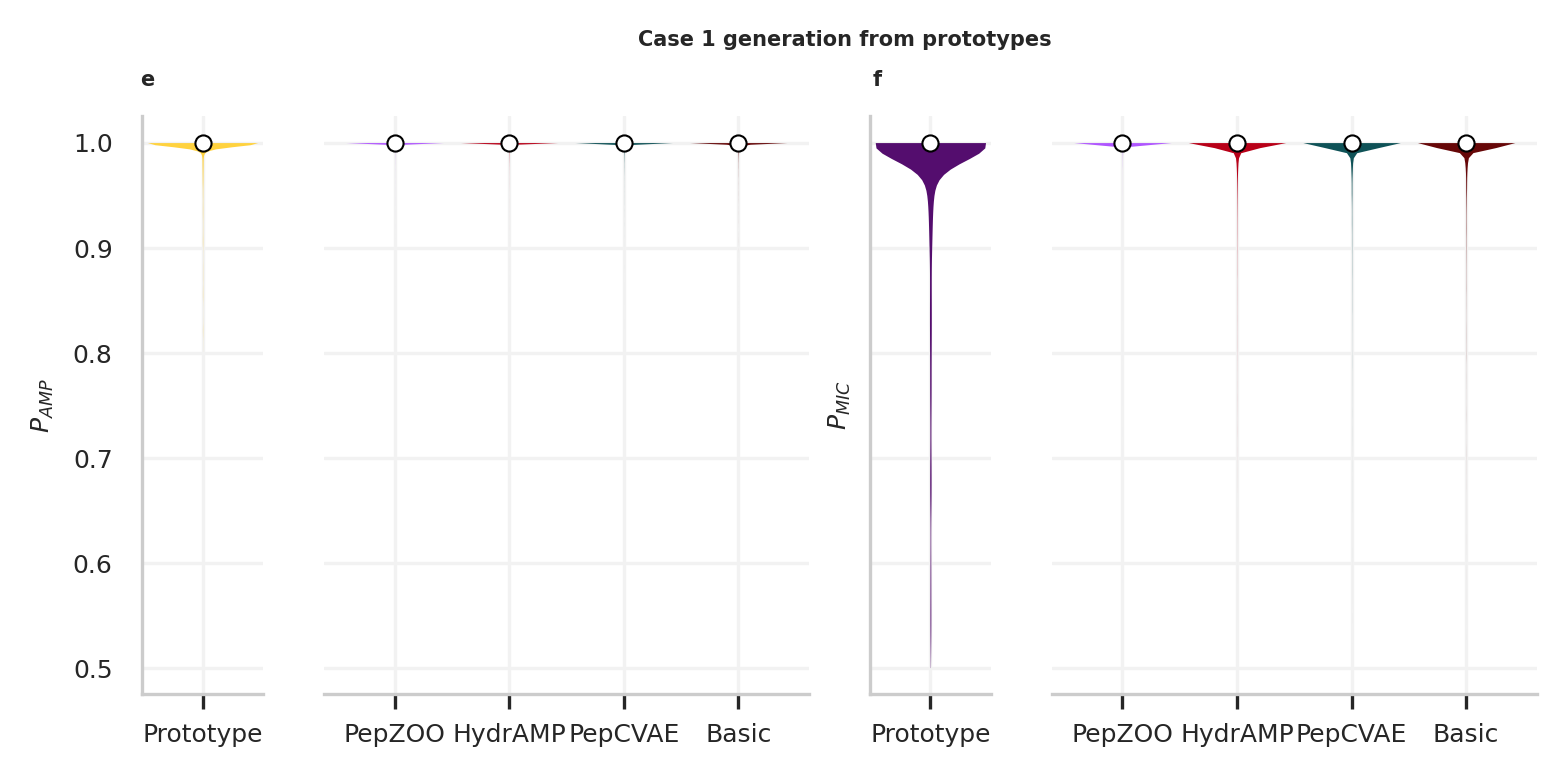

In [10]:
hydr_file_path = '../../result/hydramp/mic_case1.csv'
pepcvae_file_path  = '../../result/pepcvae/case1_result.csv'
basic_file_path = '../../result/basic/case1_result.csv'
prototype_amp_list, prototype_mic_list, data = get_amp_mic_data(hydr_file_path, pepcvae_file_path, basic_file_path)
fig = plot_classifier_distribution(data, prototype_amp_list, prototype_mic_list)
fig.savefig("../figures/figure/mic_case1_amp_mic.svg")
plt.show()

## optimize amp and mic

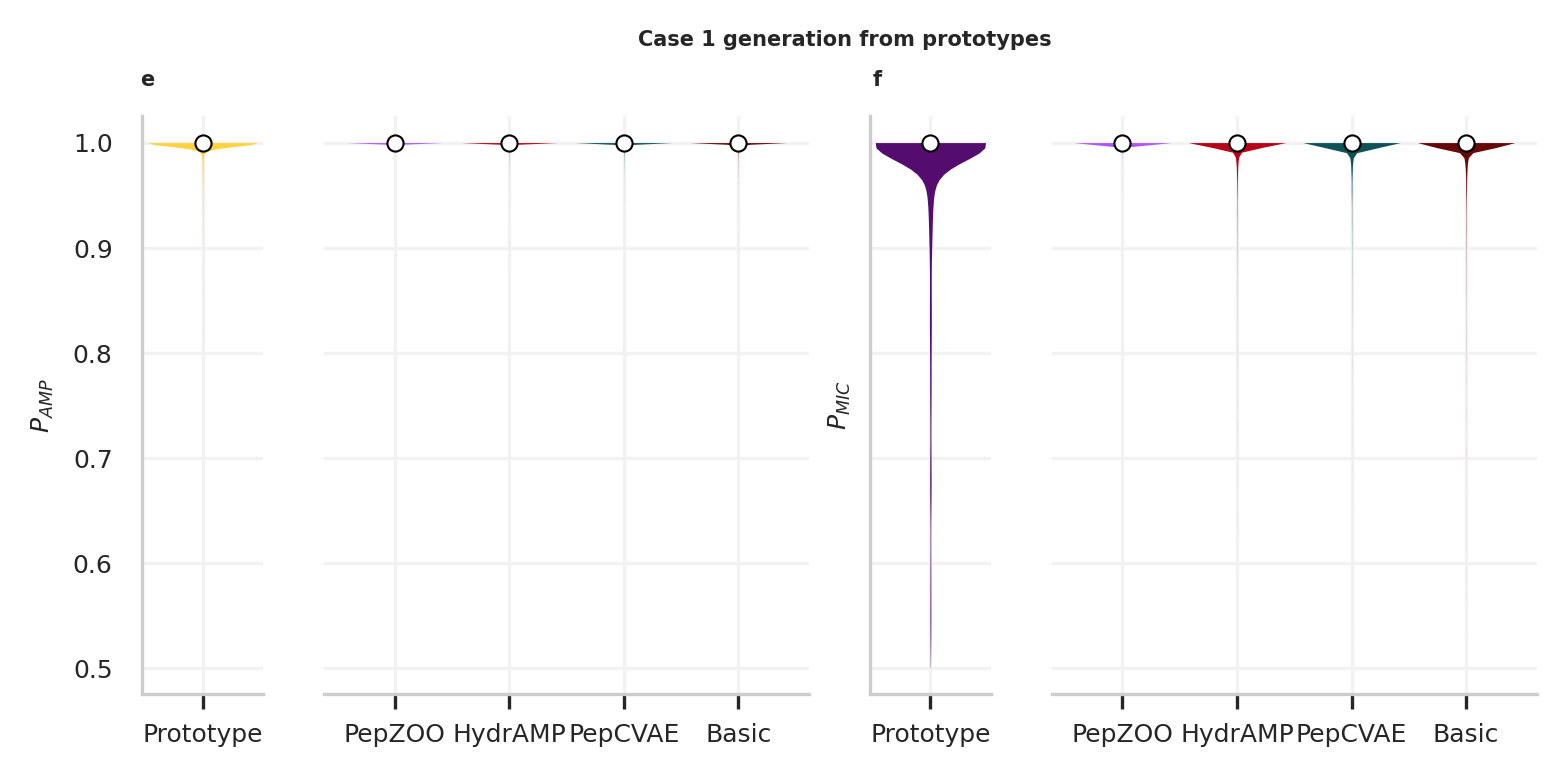

In [11]:
hydr_file_path = '../../result/hydramp/amp_mic_case1.csv'
pepcvae_file_path  = '../../result/pepcvae/case1_result.csv'
basic_file_path = '../../result/basic/case1_result.csv'
prototype_amp_list, prototype_mic_list, data = get_amp_mic_data(hydr_file_path, pepcvae_file_path, basic_file_path)
fig = plot_classifier_distribution(data, prototype_amp_list, prototype_mic_list)
fig.savefig("../figures/figure/amp_mic_case1_amp_mic.svg")
plt.show()